In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('whitegrid')

# read in the data
file_names = ["school1.dat", "school2.dat", "school3.dat"]

dfs = []
for i, fnm in enumerate(file_names):
    d = pd.read_table(fnm, header=None, names=['time'])
    d['school'] = fnm.split('.')[0]
    dfs.append(d)

df = pd.concat(dfs).reset_index(drop=True)

# priors parameters
mu0 = 5
kappa0 = 1
v0 = 2
sigma0_sq = 4

# school sufficient statistics
gp = df.groupby('school')
ns = gp.time.size()
y_bars = gp.time.mean()
vars = gp.time.var()

# posterior parameters
kns = kappa0 + ns
muns = (kappa0*mu0 + ns*y_bars) / kns
vns = v0 + ns
sigmans_sq = 1/vns * ((ns-1)*vars + v0*sigma0_sq + (kappa0*ns/kns)*(y_bars-mu0)**2)


np.random.seed(12123)

# drawing precision samples
precision_samples = stats.gamma(a=vns/2, scale=2/(vns*sigmans_sq)).rvs(size=(100000, 3))
vars_samples = 1 / precision_samples

# drawing mu samples given the precision samples
theta_samples = stats.norm(loc=muns, scale=np.sqrt(vars_samples/kns.values)).rvs()

In [11]:
pd.DataFrame(theta_samples).quantile((0.025, 0.975))

,0,1,2
0.025,7.768136,5.140580,6.165288
0.975,10.824765,8.733903,9.446978


In [13]:
pd.DataFrame(theta_samples).mean()

0    9.292008
1    6.943064
2    7.812310
dtype: float64

In [10]:
pd.DataFrame(np.sqrt(vars_samples)).quantile((0.025, 0.975))

,0,1,2
0.025,3.002397,3.345259,2.803659
0.975,5.175238,5.882706,5.125820


In [12]:
pd.DataFrame(np.sqrt(vars_samples)).mean()

0    3.906906
1    4.394512
2    3.749485
dtype: float64

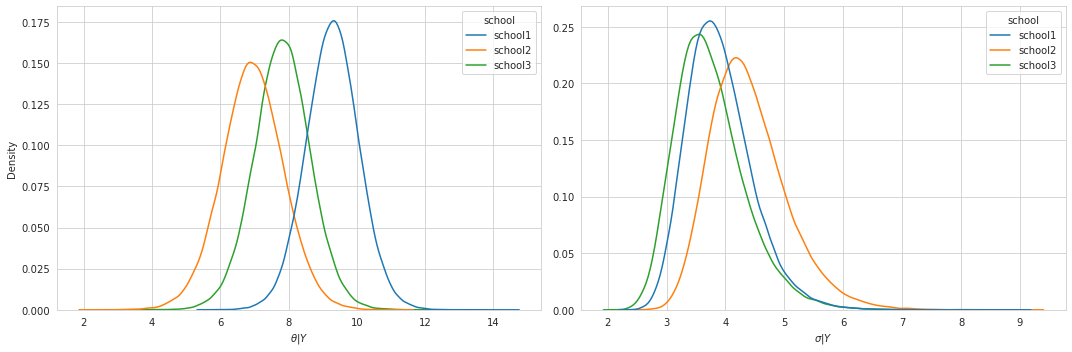

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

to_plot = (
    pd.DataFrame(theta_samples, columns=['school1','school2','school3'])
      .unstack().reset_index()
      .drop('level_1', axis=1)
)
to_plot.columns = ['school', 'mu']
sns.kdeplot(data=to_plot, x='mu', hue='school', ax=ax[0])
ax[0].set_xlabel("$\\theta|Y$")

to_plot = (
    pd.DataFrame(vars_samples, columns=['school1','school2','school3'])
      .unstack().reset_index()
      .drop('level_1', axis=1)
)
to_plot.columns = ['school', 'vars']
sns.kdeplot(data=to_plot, x=np.sqrt(to_plot.vars), hue='school', ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("$\\sigma|Y$")

fig.tight_layout()
fig.show()